<h1><center>XOR Project</center><h1>

### Introduction
- This project aims to solve the classical XOR problem by using the machine learning based methods with Pytorch.

### Problem Definition
- Dataset: 200 training examples, 100 validation examples, 100 test examples
- Each example contains 2 features drawn from the unifrom distribution between [-1, 1)
- The label is 0 if the product between 2 features is smaller than 0 else 1

### 1. Dataset

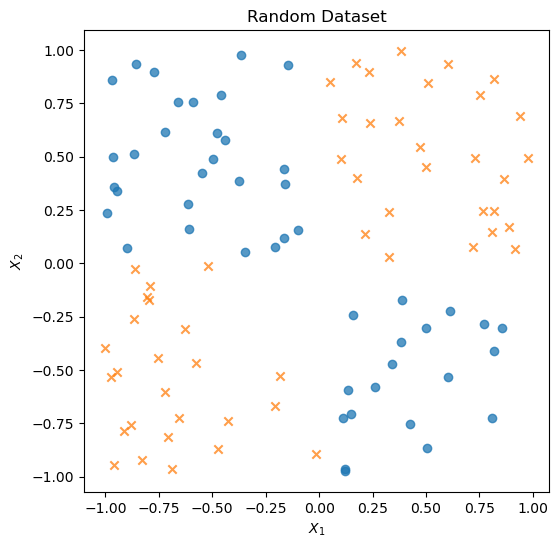

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from torch.utils.data import DataLoader, TensorDataset

# Train Dataset: 1, Validation Dataset: 2, Test Dataset: 3

def generateDataLoader(size:int, batchSize:int, seed:int, featureNumber:int=2) -> DataLoader:
    '''
        By default, all dataloader uses shuffling for better performance
    '''
    dataset, label = generateNumpyDataset(size, seed, featureNumber)
    dataset, label = torch.tensor(dataset, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

    tensorDataset = TensorDataset(dataset, label)

    return DataLoader(tensorDataset, batchSize, shuffle=True)

def generateNumpyDataset(size:int, seed:int, featureNumber:int) -> tuple[np.ndarray, np.ndarray]:
    '''
        Return a dataset that is sampled from the uniform distribution bewteen -1 and 1
    '''
    np.random.seed(seed)

    data = np.random.uniform(-1, 1, (size, featureNumber))
    label = np.ones(size)
    label[data[:,0]*data[:,1] < 0] = 0

    return data, label

def plotNumpyDataset(data:np.ndarray, label:np.ndarray, title:str):
    '''
        Plot the dataset using different symbols for different classes
    '''
    figure = plt.figure(figsize=(6,6))

    plt.scatter(data[label==0, 0], data[label==0, 1], marker="o", alpha=0.75)
    plt.scatter(data[label==1, 0], data[label==1, 1], marker="x", alpha=0.75)

    plt.xlabel(r"$X_1$")
    plt.ylabel(r"$X_2$")
    plt.title(title)

    plt.show()

data, label = generateNumpyDataset(100, 1, 2)
plotNumpyDataset(data, label, "Random Dataset")

### 2. Pytorch Model
- The model is consisted of 3 linear layers (with ReLU activation function) + the final Sigmoid layer as output layer
- A small zero-mean Gaussian noise is added at the first layer to regularise the model and avoid the overfitting problem only during the training process

In [2]:
import torch

from torch import nn

class NoisyLinear(nn.Module):
    '''
        Customized initialisation + noise during the training
    '''
    def __init__(self, inputFeature:int, outputFeature:int, noiseSTD:float):
        super().__init__()

        self.weight = nn.Parameter(self.constructWeight(inputFeature, outputFeature))
        self.offset = nn.Parameter(self.constructOffset(outputFeature))
        self.noiseSTD = noiseSTD
    
    def forward(self, input:torch.Tensor, training:bool=False) -> torch.Tensor:
        '''
            Only add a random zero-mean Gaussain noise to the input during the training process
        '''
        if training:
            noise = torch.normal(0, self.noiseSTD, input.shape)
            input = torch.add(input, noise)
        
        return torch.add(torch.mm(input, self.weight), self.offset)
    
    def constructWeight(self, inputFeature:int, outputFeature:int) -> torch.Tensor:
        '''
            By default, the weight of the layer is initialised by xavier uniform
        '''
        weight = torch.Tensor(inputFeature, outputFeature)
        nn.init.xavier_uniform_(weight)

        return weight
    
    def constructOffset(self, outputFeature:int) -> torch.Tensor:
        '''
            By default, the offset of the layer is initilised by filling 0
        '''
        offset = torch.Tensor(outputFeature).fill_(0)

        return offset

In [3]:
import torch

from torch import nn

class NoisyModel(nn.Module):
    '''
        3 (Linear + ReLU) + Sigmoid
    '''
    def __init__(self, inputFeature:int, outputFeature:int, noiseSTD:float):
        super(NoisyModel, self).__init__()

        self.noisyLayer = NoisyLinear(inputFeature, inputFeature*2, noiseSTD)
        self.layer = nn.Sequential(
            nn.ReLU(),
            nn.Linear(inputFeature*2, inputFeature*2),
            nn.ReLU(),
            nn.Linear(inputFeature*2, outputFeature),
            nn.Sigmoid()
        )
    
    def forward(self, input:torch.Tensor, training:bool=False) -> torch.Tensor:
        result = self.noisyLayer(input, training)
        result = self.layer(result)

        return result.flatten()
    
    def predict(self, input:np.ndarray) -> torch.Tensor:
        input = torch.from_numpy(input).float()
        result = self.forward(input)

        return (result >= 0.5 ).float()

### 3. Train, Validaiton, Test and Evaluation

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch

from mlxtend.plotting import plot_decision_regions
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader

def train(
    epoch:int,
    trainDataLoader:DataLoader,
    validationDataLoader:DataLoader,
    model:NoisyModel,
    optimiser:Adam,
    loss:nn.BCELoss
) -> tuple[list[float], list[float], list[float], list[float]]:
    trainLoss, trainAccuracy, validationLoss, validationAccuracy = [], [], [], []

    for _ in range(epoch):
        startTime = time.time()

        model.eval()
        with torch.no_grad():
            validationLossEpoch, validationAccuracyEpoch = validateEpoch(validationDataLoader, model, loss)
            validationLoss.append(validationLossEpoch), validationAccuracy.append(validationAccuracyEpoch)
        
        model.train()
        trainLossEpoch, trainAccuracyEpoch = trainEpoch(trainDataLoader, model, optimiser, loss)
        trainLoss.append(trainLossEpoch), trainAccuracy.append(trainAccuracyEpoch)

        endTime = time.time()

        print(
            'Epoch : ',len(trainLoss), '\t',
            'Train Loss: ',np.format_float_scientific(trainLoss[-1], 3), '\t',
            'Train Accuracy: ', "{:%}".format(trainAccuracy[-1]), '\t',
            "Validation Loss: ", np.format_float_scientific(validationLoss[-1], 3), '\t',
            "Validation Accuracy", "{:%}".format(validationAccuracy[-1]), '\t',
            'Time: ', "{:.3f}".format(endTime-startTime), "s")
    
    return trainLoss, trainAccuracy, validationLoss, validationAccuracy

def validateEpoch(validationDataLoader:DataLoader, model:NoisyModel, loss:nn.BCELoss) -> tuple[float, float]:
    validationLossEpoch = 0
    validationAccuracyEpoch = 0

    for validationDataBatch, validationLabelBatch in validationDataLoader:
        validationLossEpoch, validationAccuracyEpoch = validateBatch(validationLossEpoch, validationAccuracyEpoch, validationDataBatch, validationLabelBatch, model, loss)
    
    return validationLossEpoch/len(validationDataLoader), validationAccuracyEpoch/len(validationDataLoader)

def validateBatch(
    validationLossEpoch:float,
    validationAccuracyEpoch:float,
    validationDataBatch:torch.Tensor,
    validationLabelBatch:torch.Tensor,
    model:NoisyModel,
    loss:nn.BCELoss
) -> tuple[float, float]:
    prediction = model.forward(validationDataBatch)

    validationLossBatch = loss(prediction, validationLabelBatch)

    validationLossEpoch += validationLossBatch.item()
    validationAccuracyEpoch += ((prediction >= 0.5) == validationLabelBatch).float().mean()

    return validationLossEpoch, validationAccuracyEpoch

def trainEpoch(trainDataLoader:DataLoader, model:NoisyModel, optimiser:Adam, loss:nn.BCELoss) -> tuple[float, float]:
    trainLossEpoch = 0
    trainAccuracyEpoch = 0

    for trainDataBatch, trainLabelBatch in trainDataLoader:
        trainLossEpoch, trainAccuracyEpoch = trainBatch(trainLossEpoch, trainAccuracyEpoch, trainDataBatch, trainLabelBatch, model, optimiser, loss)
    
    return trainLossEpoch/len(trainDataLoader), trainAccuracyEpoch/len(trainDataLoader)

def trainBatch(
    trainLossEpoch:float,
    trainAccuracyEpoch:float,
    trainDataBatch:torch.Tensor,
    trainLabelBatch:torch.Tensor,
    model:NoisyModel,
    optimiser:Adam,
    loss:nn.BCELoss
) -> tuple[float, float]:
    prediction = model.forward(trainDataBatch, True)

    optimiser.zero_grad()
    trainLossBatch = loss(prediction, trainLabelBatch)
    trainLossBatch.backward()
    optimiser.step()

    trainLossEpoch += trainLossBatch.item()
    trainAccuracyEpoch += ((prediction >= 0.5) == trainLabelBatch).float().mean()

    return trainLossEpoch, trainAccuracyEpoch

def test(
    testDataLoader:DataLoader,
    model:NoisyModel,
    loss:nn.BCELoss
):
    testLoss = 0
    testAccuracy = 0

    model.eval()
    with torch.no_grad():
        for testDataBatch, testLabelBatch in testDataLoader:
            testLoss, testAccuracy = validateBatch(testLoss, testAccuracy, testDataBatch, testLabelBatch, model, loss)

    print(
        "Test Loss: ", np.format_float_scientific(testLoss/len(testDataLoader), 2), '\t',
        "Test Accuracy: ", "{:%}".format(testAccuracy/len(testDataLoader)), '\t'
    )

def evaluate(
    trainLoss:list[float],
    trainAccuracy:list[float],
    validationLoss:list[float],
    validationAccuracy:list[float],
    testData:np.ndarray,
    testLabel:np.ndarray,
    model:NoisyModel
):
    figure = plt.figure(figsize=(16, 4))

    lossAxis = figure.add_subplot(1, 3, 1)
    plt.plot(trainLoss, lw=2)
    plt.plot(validationLoss, lw=2)
    plt.legend(["Train Loss", "Validation Loss"])
    lossAxis.set_xlabel("Epoch")
    lossAxis.set_ylabel("Train/Validaiton Loss")

    accuracyAxis = figure.add_subplot(1, 3, 2)
    plt.plot(trainAccuracy, lw=2)
    plt.plot(validationAccuracy, lw=2)
    plt.legend(["Train Accuracy", "Validation Accuracy"])
    accuracyAxis.set_xlabel("Epoch")
    accuracyAxis.set_ylabel("Train/Validation Accuracy")

    decisionAxis = figure.add_subplot(1, 3, 3)
    plot_decision_regions(
        testData, testLabel.astype("int8"), model
    )
    decisionAxis.set_xlabel(r"$X_1$")
    decisionAxis.set_ylabel(r"$X_2$")

    plt.show()

### 4. Experiment
- Epoch: 200
- Batch Size: 2, the size of the dataset is too small => requires a small batch size for more gradient calculation and update
- Learning Rate: 1e-3, try a small learning rate first to work with a small batch size
- Optimizer: Adam, auto adapted learning rate for better training process
- Loss: Binary Cross Entropy Loss, very suitable for 2-class classification problems
- Device: CPU, the data size is relatively small

Epoch :  1 	 Train Loss:  6.964e-01 	 Train Accuracy:  52.999997% 	 Validation Loss:  7.006e-01 	 Validation Accuracy 51.999998% 	 Time:  0.273 s
Epoch :  2 	 Train Loss:  6.928e-01 	 Train Accuracy:  52.999997% 	 Validation Loss:  6.962e-01 	 Validation Accuracy 51.999998% 	 Time:  0.243 s
Epoch :  3 	 Train Loss:  6.892e-01 	 Train Accuracy:  52.999997% 	 Validation Loss:  6.926e-01 	 Validation Accuracy 51.999998% 	 Time:  0.277 s
Epoch :  4 	 Train Loss:  6.842e-01 	 Train Accuracy:  52.999997% 	 Validation Loss:  6.884e-01 	 Validation Accuracy 51.999998% 	 Time:  0.278 s
Epoch :  5 	 Train Loss:  6.785e-01 	 Train Accuracy:  52.999997% 	 Validation Loss:  6.819e-01 	 Validation Accuracy 51.999998% 	 Time:  0.250 s
Epoch :  6 	 Train Loss:  6.702e-01 	 Train Accuracy:  52.999997% 	 Validation Loss:  6.746e-01 	 Validation Accuracy 51.999998% 	 Time:  0.270 s
Epoch :  7 	 Train Loss:  6.612e-01 	 Train Accuracy:  54.000002% 	 Validation Loss:  6.658e-01 	 Validation Accuracy 51.999

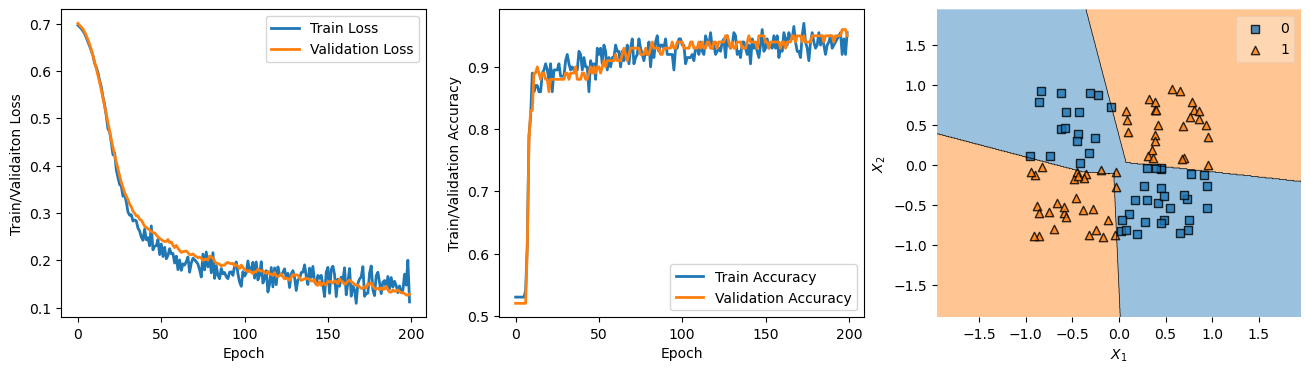

In [5]:
epoch = 200
batchSize = 2
learningRate = 1e-3
model = NoisyModel(inputFeature=2, outputFeature=1, noiseSTD=0.1)
optimiser = Adam(model.parameters(), learningRate, (0.9, 0.99))
loss = nn.BCELoss()

trainDataLoader = generateDataLoader(200, batchSize, 1)
validationDataLoader = generateDataLoader(100, batchSize, 2)
testData, testLabel = generateNumpyDataset(100, 3, 2)
testDataLoader = generateDataLoader(100, 2, 3)

trainLoss, trainAccuracy, validationLoss, validationAccuracy = train(epoch, trainDataLoader, validationDataLoader, model, optimiser, loss)
print(" ")
print("----------")
print(" ")
test(testDataLoader, model, loss)
evaluate(trainLoss, trainAccuracy, validationLoss, validationAccuracy, testData, testLabel, model)

### 5. Result and Discussion
- The model could achieve 97% accuracy on the test dataset, which is quite impressive. This shows that the current design is good enough to solve this relatively simple problem.
- From both loss/accuracy plots it could be clearly seen that it might not reach the optimal convergence as both loss and accuracy are still fluctuating at high epochs. This might also be the effect brought by the added Gaussian noise. Increasing the size of dataset or increasing the epoch number might be able to solve this problem.